In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns

In [69]:
photo_directory = 'C:/Users/User/Downloads/text/train'
photo_files = [f for f in os.listdir(photo_directory) if os.path.isfile(os.path.join(photo_directory, f))]

# Загрузка меток классов из TSV файла
tsv_filepath = 'C:/Users/User/Downloads/text/train.tsv'
class_labels = pd.read_csv(tsv_filepath, sep='\t', header=None, names=['file', 'label'])

# Объединение фотографий и меток классов по именам файлов
photo_train = pd.DataFrame({'file': photo_files})
photo_train = pd.merge(photo_train, class_labels, on='file', how='inner')

In [70]:
photo_train

,file,label
0,aa1.png,Молдова
1,aa1007.png,продолжила борьбу
2,aa101.png,разработанные
3,aa1012.png,Плачи
4,aa1013.png,Гимны богам
...,...,...
72281,yt94.png,д.3 кв.7
72282,yt95.png,д.3 кв.7
72283,yt96.png,д.3 кв.7
72284,yt97.png,д.3


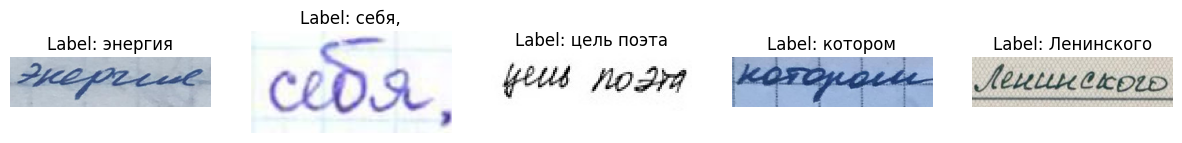

In [71]:
import matplotlib.pyplot as plt

sample_photos = photo_train.sample(n=5)

fig, axes = plt.subplots(1, len(sample_photos), figsize=(15, 5))

for ax, (index, row) in zip(axes, sample_photos.iterrows()):
    image_path = os.path.join(photo_directory, row['file'])
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    ax.imshow(image_rgb)
    ax.set_title(f"Label: {row['label']}")
    ax.axis('off')

plt.show()


In [72]:
def load_and_preprocess_images(file_paths, directory):
    images = []
    for file_path in file_paths:
        # Пример: Загрузка изображений с использованием OpenCV
        image = cv2.imread(os.path.join(directory, file_path), cv2.IMREAD_GRAYSCALE)
        # Пример: Предобработка изображений
        image = cv2.resize(image, (28, 28))
        image = image.astype('float32') / 255.0  # Нормализация
        images.append(image)
    return np.array(images)

photo_train = photo_train.fillna(0)
photo_train = photo_train.dropna()
photo_train = photo_train.dropna(axis=1)
print(photo_train.isnull().sum())

# Определение минимального количества экземпляров для класса
min_samples_per_class = 10

# Выбор наиболее часто встречающихся классов с учетом минимального количества экземпляров
selected_classes = photo_train['label'].value_counts()[photo_train['label'].value_counts() >= min_samples_per_class].index

# Отфильтровать DataFrame по выбранным классам
filtered_photo_train = photo_train[photo_train['label'].isin(selected_classes)]

# Использование StratifiedKFold с фильтрованными данными
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_data = pd.DataFrame(columns=['file', 'label'])
test_data = pd.DataFrame(columns=['file', 'label'])

for train_index, test_index in stratified_kfold.split(filtered_photo_train['file'], filtered_photo_train['label']):
    train_data = pd.concat([train_data, filtered_photo_train.iloc[train_index]])
    test_data = pd.concat([test_data, filtered_photo_train.iloc[test_index]])

# Проверка минимального количества образцов в каждом классе
print(train_data['label'].value_counts())
print(test_data['label'].value_counts())

# Пример предобработки изображений (предполагается, что у вас есть функция load_and_preprocess_images)
train_images = load_and_preprocess_images(train_data['file'].values, photo_directory)
test_images = load_and_preprocess_images(test_data['file'].values, photo_directory)

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_data['label'].values)
test_labels_encoded = label_encoder.transform(test_data['label'].values)

# Преобразование меток в one-hot encoding
train_labels = to_categorical(train_labels_encoded)
test_labels = to_categorical(test_labels_encoded)


file     0
label    0
dtype: int64
что              1384
на               1036
если              876
при               860
или               716
                 ... 
экономических      40
системе            40
потребностей       40
девочка            40
Молдова            40
Name: label, Length: 845, dtype: int64
что           346
на            259
если          219
при           215
или           179
             ... 
глаза          10
расстояние     10
дей            10
таким          10
Учебные        10
Name: label, Length: 845, dtype: int64


In [75]:
num_classes = 845

inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [76]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',  # используйте 'sparse_categorical_crossentropy', если ваши метки не one-hot encoded
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(test_images, test_labels))

Epoch 1/5
1159/1159 [==============================] - 44s 38ms/step - loss: 5.0598 - accuracy: 0.1449 - val_loss: 3.1125 - val_accuracy: 0.3673
Epoch 2/5
1159/1159 [==============================] - 44s 38ms/step - loss: 2.5931 - accuracy: 0.4574 - val_loss: 2.0413 - val_accuracy: 0.5501
Epoch 3/5
1159/1159 [==============================] - 43s 38ms/step - loss: 1.6929 - accuracy: 0.6137 - val_loss: 1.3496 - val_accuracy: 0.6730
Epoch 4/5
1159/1159 [==============================] - 46s 40ms/step - loss: 1.1217 - accuracy: 0.7258 - val_loss: 0.8714 - val_accuracy: 0.7763
Epoch 5/5
1159/1159 [==============================] - 45s 39ms/step - loss: 0.7159 - accuracy: 0.8153 - val_loss: 0.5347 - val_accuracy: 0.8591


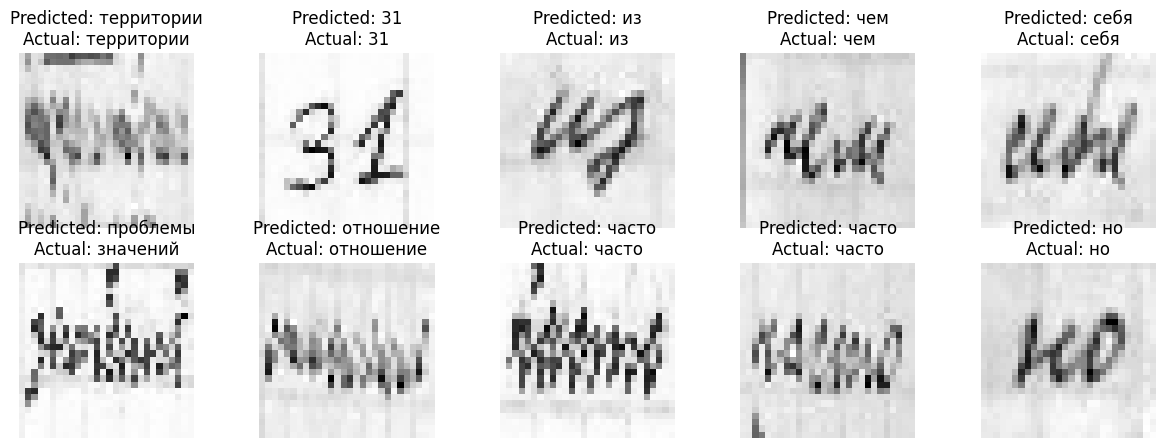

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Предсказание на тестовых данных
predictions = model.predict(test_images)

# Получение индекса класса с наивысшей вероятностью для каждого изображения
predicted_classes = np.argmax(predictions, axis=1)

# Обратное кодирование меток в текстовый формат
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Отображение нескольких изображений с предсказанными метками
num_images_to_display = 10
plt.figure(figsize=(15, 5))
for i in range(num_images_to_display):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i].reshape((28, 28)), cmap='gray')
    plt.title(f'Predicted: {predicted_labels[i]}\nActual: {test_data.iloc[i]["label"]}')
    plt.axis('off')
plt.show()


In [83]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

580/580 [==============================] - 3s 5ms/step - loss: 0.5347 - accuracy: 0.8591


0.8590546250343323

In [84]:
test_loss

0.5347098112106323